In [3]:
import os
import tarfile
import re
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import zipfile
from datetime import datetime

# rtcor Radar Data

In [2]:
path_ds = '/nobackup_1/users/schreurs/project_GAN/dataset_radar'

In [2]:
ls /nobackup_1/users/schreurs/project_GAN/dataset_radar | head -5

RAD25_OPER_R___TARRRT__L2__20181219080000_20181220075500_0001.tar
RAD25_OPER_R___TARRRT__L2__20181220080000_20181221075500_0001.tar
RAD25_OPER_R___TARRRT__L2__20181221080000_20181222075500_0001.tar
RAD25_OPER_R___TARRRT__L2__20181222T080500_20181223T080000_0001.tar
RAD25_OPER_R___TARRRT__L2__20181223T080500_20181224T080000_0001.tar
ls: write error


In [3]:
files = sorted([f for f in os.listdir(path_ds) if os.path.isfile(os.path.join(path_ds, f))])
print("Number of days in dataset = ", len(files))

Number of days in dataset =  228474


## Unpack tar files

In [10]:
# Testing path
tar_path = path_ds + '/' + files[0]
print("tar path: ", tar_path)
print("unpack in folder: ", path_ds)

tar path:  /nobackup/users/schreurs/project_GAN/dataset_radar/RAD25_OPER_R___TARRRT__L2__20181219080000_20181220075500_0001.tar
unpack in folder:  /nobackup/users/schreurs/project_GAN/dataset_radar


In [11]:
for file in tqdm(files):
    tar_path = path_ds + '/' + file
    
    tar_file = tarfile.open(tar_path)
    tar_file.extractall(path_ds)
    tar_file.close()

100%|██████████| 795/795 [06:50<00:00,  1.94it/s]


In [4]:
radar_scans = sorted([f for f in os.listdir(path_ds) if (os.path.isfile(os.path.join(path_ds, f)) and f.endswith('.h5'))])
print("Number of scans in dataset = ", len(radar_scans))

Number of scans in dataset =  227679


In [5]:
radar_scans[0]

'RAD_NL25_RAC_RT_201812190800.h5'

## Checking for missing data

In [2]:
regex_timestamp = re.compile('(\d{12})\.h5')
def get_datetime(filename):
    '''
    Infer datetime from filename
    '''
    timestamp=None
    dt=None
    # check if regex pattern finds a timestamp
    try:
        timestamp = regex_timestamp.findall(filename)[0] 
        dt = datetime.strptime(str(timestamp), '%Y%m%d%H%M')
    except:
        print('Error: could not find timestamp in file {}'.format(filename))
    return dt

In [3]:
def get_diff_minutes(d1, d2):
    '''
    Returns the difference in minutes between first date d1 and the next date d2
    '''
    diff = int((d2-d1).seconds / 60)
    return diff

In [4]:
def gap_between(filename1, filename2):
    '''
    Checks if difference in time between two consecutive files is 5 minutes.
    If it is not, print the two timestamps
    Returns the number of scans missing between two files (time difference/5)
    '''
    d1 = get_datetime(filename1)
    d2 = get_datetime(filename2)
    
    diff = get_diff_minutes(d1, d2)
    
    if diff != 5:
        print('{} minutes gap between {} and {}'.format(diff,d1,d2))
        return diff/5
    return 0

In [54]:
gaps=[]
for i in range(0,len(radar_scans)-1):
    # check if tim
    gap_size = gap_between(radar_scans[i],radar_scans[i+1])
    if  gap_size != 0:
        gaps.append([radar_scans[i], radar_scans[i+1], gap_size])
gaps=np.array(gaps)
print('There are {} gaps in the data'.format(len(gaps)))  
nr_missing_scans=int(sum(map(float, gaps[:,2])))
total_scans = (len(radar_scans) + nr_missing_scans)
perc_missing = nr_missing_scans/total_scans
print('Missing {} out of the {} radar scans ({:.2f}%)'.format(nr_missing_scans, total_scans, perc_missing))
print('From {} till {}'.format(get_datetime(radar_scans[0]), get_datetime(radar_scans[-1])))

10 minutes gap between 2018-12-19 10:25:00 and 2018-12-19 10:35:00
15 minutes gap between 2018-12-19 10:45:00 and 2018-12-19 11:00:00
30 minutes gap between 2018-12-19 13:15:00 and 2018-12-19 13:45:00
10 minutes gap between 2018-12-19 14:10:00 and 2018-12-19 14:20:00
65 minutes gap between 2018-12-19 14:30:00 and 2018-12-19 15:35:00
15 minutes gap between 2018-12-19 18:40:00 and 2018-12-19 18:55:00
40 minutes gap between 2018-12-19 19:40:00 and 2018-12-19 20:20:00
120 minutes gap between 2018-12-19 20:30:00 and 2018-12-19 22:30:00
170 minutes gap between 2018-12-19 22:35:00 and 2018-12-20 01:25:00
15 minutes gap between 2018-12-20 01:25:00 and 2018-12-20 01:40:00
10 minutes gap between 2018-12-20 09:15:00 and 2018-12-20 09:25:00
10 minutes gap between 2018-12-20 12:10:00 and 2018-12-20 12:20:00
10 minutes gap between 2018-12-20 21:15:00 and 2018-12-20 21:25:00
10 minutes gap between 2018-12-21 17:25:00 and 2018-12-21 17:35:00
15 minutes gap between 2018-12-21 21:35:00 and 2018-12-21 21

10 minutes gap between 2019-02-07 09:10:00 and 2019-02-07 09:20:00
10 minutes gap between 2019-02-07 17:10:00 and 2019-02-07 17:20:00
10 minutes gap between 2019-02-08 00:20:00 and 2019-02-08 00:30:00
10 minutes gap between 2019-02-08 00:45:00 and 2019-02-08 00:55:00
10 minutes gap between 2019-02-08 04:10:00 and 2019-02-08 04:20:00
10 minutes gap between 2019-02-08 13:55:00 and 2019-02-08 14:05:00
10 minutes gap between 2019-02-08 16:30:00 and 2019-02-08 16:40:00
10 minutes gap between 2019-02-08 21:30:00 and 2019-02-08 21:40:00
130 minutes gap between 2019-02-08 23:05:00 and 2019-02-09 01:15:00
65 minutes gap between 2019-02-09 01:30:00 and 2019-02-09 02:35:00
10 minutes gap between 2019-02-09 06:10:00 and 2019-02-09 06:20:00
10 minutes gap between 2019-02-09 10:55:00 and 2019-02-09 11:05:00
10 minutes gap between 2019-02-09 11:10:00 and 2019-02-09 11:20:00
10 minutes gap between 2019-02-09 17:40:00 and 2019-02-09 17:50:00
10 minutes gap between 2019-02-09 18:10:00 and 2019-02-09 18:

## Open the H5 files

In [ ]:
for file in tqdm(radar_scans[52878-1:]):
    fp = '/nobackup_1/users/schreurs/project_GAN/dataset_radar/{}'.format(file)
    rdr =h5py.File(fp, 'r')
    
    try:
        mis = rdr['image1']['calibration'].attrs['calibration_out_of_image']
        img = rdr['image1']['image_data']
        if mis != 65535:
            print(file, mis)
        if img[0,0] != 65535:
            print(file, img[0,0])
    except:
        print('error', file)
        img = rdr['image1']['image_data']
        print(img)
        print(img.shape)
        plt.imshow(img)

  0%|          | 18/174802 [00:00<30:19, 96.04it/s] 

error RAD_NL25_RAC_RT_201906222155.h5
<HDF5 dataset "image_data": shape (765, 700), type "<u2">
(765, 700)


  0%|          | 65/174802 [00:00<20:51, 139.67it/s]

RAD_NL25_RAC_RT_201906230110.h5 255


  0%|          | 212/174802 [00:01<14:18, 203.40it/s]

RAD_NL25_RAC_RT_201906231050.h5 255


  0%|          | 310/174802 [00:01<08:41, 334.34it/s]

RAD_NL25_RAC_RT_201906231830.h5 255
RAD_NL25_RAC_RT_201906232005.h5 255
RAD_NL25_RAC_RT_201906232150.h5 255


  0%|          | 524/174802 [00:02<07:46, 373.94it/s]

RAD_NL25_RAC_RT_201906241150.h5 255
RAD_NL25_RAC_RT_201906241830.h5 255
RAD_NL25_RAC_RT_201906241835.h5 255
RAD_NL25_RAC_RT_201906241840.h5 255


  0%|          | 608/174802 [00:02<07:35, 382.03it/s]

RAD_NL25_RAC_RT_201906241950.h5 255
RAD_NL25_RAC_RT_201906242155.h5 255


  0%|          | 733/174802 [00:02<09:55, 292.22it/s]

RAD_NL25_RAC_RT_201906250805.h5 255


  1%|          | 910/174802 [00:03<07:05, 408.25it/s]

RAD_NL25_RAC_RT_201906251750.h5 255
RAD_NL25_RAC_RT_201906251805.h5 255
RAD_NL25_RAC_RT_201906251830.h5 255
RAD_NL25_RAC_RT_201906251850.h5 255
RAD_NL25_RAC_RT_201906251910.h5 255
RAD_NL25_RAC_RT_201906251920.h5 255
RAD_NL25_RAC_RT_201906251950.h5 255
RAD_NL25_RAC_RT_201906252050.h5 255
RAD_NL25_RAC_RT_201906252205.h5 255


  1%|          | 1480/174802 [00:04<05:38, 511.78it/s]

RAD_NL25_RAC_RT_201906271745.h5 255
RAD_NL25_RAC_RT_201906271835.h5 255
RAD_NL25_RAC_RT_201906271900.h5 255
RAD_NL25_RAC_RT_201906271920.h5 255


  1%|          | 1583/174802 [00:04<07:04, 408.47it/s]

RAD_NL25_RAC_RT_201906280750.h5 255


  1%|          | 1719/174802 [00:05<14:13, 202.80it/s]

RAD_NL25_RAC_RT_201906281905.h5 255
RAD_NL25_RAC_RT_201906282005.h5 255


  1%|          | 1831/174802 [00:06<16:43, 172.29it/s]

error RAD_NL25_RAC_RT_201906290420.h5
<HDF5 dataset "image_data": shape (765, 700), type "<u2">
(765, 700)


  1%|          | 1867/174802 [00:06<18:54, 152.41it/s]

RAD_NL25_RAC_RT_201906290805.h5 255
RAD_NL25_RAC_RT_201906290855.h5 255


  1%|          | 1985/174802 [00:07<18:10, 158.41it/s]

RAD_NL25_RAC_RT_201906291820.h5 255
RAD_NL25_RAC_RT_201906291945.h5 255


  1%|          | 2058/174802 [00:07<17:13, 167.13it/s]

RAD_NL25_RAC_RT_201906292250.h5 255
RAD_NL25_RAC_RT_201906292305.h5 255
RAD_NL25_RAC_RT_201906292350.h5 255
RAD_NL25_RAC_RT_201906300110.h5 255
RAD_NL25_RAC_RT_201906300215.h5 255


  1%|          | 2144/174802 [00:08<13:57, 206.11it/s]

RAD_NL25_RAC_RT_201906300605.h5 255
RAD_NL25_RAC_RT_201906300910.h5 255
RAD_NL25_RAC_RT_201906300925.h5 255
RAD_NL25_RAC_RT_201906300935.h5 255
RAD_NL25_RAC_RT_201906300940.h5 255


  1%|▏         | 2567/174802 [00:10<16:56, 169.51it/s]

RAD_NL25_RAC_RT_201907011805.h5 255
RAD_NL25_RAC_RT_201907011840.h5 255
RAD_NL25_RAC_RT_201907011845.h5 255
RAD_NL25_RAC_RT_201907011855.h5 255
RAD_NL25_RAC_RT_201907011900.h5 255
RAD_NL25_RAC_RT_201907011905.h5 255
RAD_NL25_RAC_RT_201907011945.h5 255
RAD_NL25_RAC_RT_201907012015.h5 255
RAD_NL25_RAC_RT_201907012035.h5 255


  2%|▏         | 2726/174802 [00:11<16:58, 168.94it/s]

RAD_NL25_RAC_RT_201907020540.h5 255
RAD_NL25_RAC_RT_201907020800.h5 255
RAD_NL25_RAC_RT_201907020855.h5 255


  2%|▏         | 2860/174802 [00:12<14:52, 192.71it/s]

RAD_NL25_RAC_RT_201907021745.h5 255
RAD_NL25_RAC_RT_201907021835.h5 255
RAD_NL25_RAC_RT_201907021910.h5 255
RAD_NL25_RAC_RT_201907021930.h5 255
RAD_NL25_RAC_RT_201907022025.h5 255
RAD_NL25_RAC_RT_201907022040.h5 255


  2%|▏         | 2944/174802 [00:12<19:12, 149.08it/s]

RAD_NL25_RAC_RT_201907030110.h5 255


  2%|▏         | 3067/174802 [00:13<20:40, 138.44it/s]

RAD_NL25_RAC_RT_201907031150.h5 255
RAD_NL25_RAC_RT_201907031340.h5 255


  2%|▏         | 3103/174802 [00:13<18:35, 153.97it/s]

RAD_NL25_RAC_RT_201907031350.h5 255
RAD_NL25_RAC_RT_201907031410.h5 255


  2%|▏         | 3154/174802 [00:13<19:12, 148.99it/s]

RAD_NL25_RAC_RT_201907031825.h5 255
RAD_NL25_RAC_RT_201907031835.h5 255
RAD_NL25_RAC_RT_201907031840.h5 255
RAD_NL25_RAC_RT_201907031850.h5 255
RAD_NL25_RAC_RT_201907031905.h5 255
RAD_NL25_RAC_RT_201907031950.h5 255
RAD_NL25_RAC_RT_201907032005.h5 255
RAD_NL25_RAC_RT_201907032010.h5 255
RAD_NL25_RAC_RT_201907032035.h5 255
RAD_NL25_RAC_RT_201907032105.h5 255
RAD_NL25_RAC_RT_201907032110.h5 255
RAD_NL25_RAC_RT_201907032125.h5 255
RAD_NL25_RAC_RT_201907032130.h5 255
RAD_NL25_RAC_RT_201907032135.h5 255
RAD_NL25_RAC_RT_201907032150.h5 255


  2%|▏         | 3206/174802 [00:14<15:10, 188.43it/s]

RAD_NL25_RAC_RT_201907032250.h5 255
RAD_NL25_RAC_RT_201907032350.h5 255
RAD_NL25_RAC_RT_201907040005.h5 255
RAD_NL25_RAC_RT_201907040105.h5 255
RAD_NL25_RAC_RT_201907040110.h5 255
RAD_NL25_RAC_RT_201907040150.h5 255


  2%|▏         | 3276/174802 [00:14<13:31, 211.38it/s]

RAD_NL25_RAC_RT_201907040245.h5 255
RAD_NL25_RAC_RT_201907040320.h5 255
RAD_NL25_RAC_RT_201907040435.h5 255
RAD_NL25_RAC_RT_201907040450.h5 255
RAD_NL25_RAC_RT_201907040550.h5 255


  2%|▏         | 3336/174802 [00:14<17:34, 162.53it/s]

RAD_NL25_RAC_RT_201907040920.h5 255
RAD_NL25_RAC_RT_201907040955.h5 255


  2%|▏         | 3353/174802 [00:15<19:58, 143.03it/s]

RAD_NL25_RAC_RT_201907041150.h5 255


  2%|▏         | 3407/174802 [00:15<19:05, 149.58it/s]

RAD_NL25_RAC_RT_201907041450.h5 255


  2%|▏         | 3441/174802 [00:15<21:23, 133.47it/s]

RAD_NL25_RAC_RT_201907041820.h5 255
RAD_NL25_RAC_RT_201907041850.h5 255
RAD_NL25_RAC_RT_201907041905.h5 255
RAD_NL25_RAC_RT_201907042055.h5 255


  2%|▏         | 3476/174802 [00:15<20:00, 142.66it/s]

RAD_NL25_RAC_RT_201907042120.h5 255
RAD_NL25_RAC_RT_201907042150.h5 255
RAD_NL25_RAC_RT_201907042205.h5 255
RAD_NL25_RAC_RT_201907042305.h5 255
RAD_NL25_RAC_RT_201907042315.h5 255
RAD_NL25_RAC_RT_201907042345.h5 255


  2%|▏         | 3505/174802 [00:16<21:40, 131.74it/s]

RAD_NL25_RAC_RT_201907050005.h5 255
RAD_NL25_RAC_RT_201907050020.h5 255
RAD_NL25_RAC_RT_201907050050.h5 255
RAD_NL25_RAC_RT_201907050110.h5 255


  2%|▏         | 3636/174802 [00:16<16:40, 171.14it/s]

RAD_NL25_RAC_RT_201907051050.h5 255


  2%|▏         | 3739/174802 [00:17<17:26, 163.46it/s]

RAD_NL25_RAC_RT_201907051805.h5 255
RAD_NL25_RAC_RT_201907051825.h5 255
RAD_NL25_RAC_RT_201907051855.h5 255
RAD_NL25_RAC_RT_201907051915.h5 255
RAD_NL25_RAC_RT_201907051925.h5 255
RAD_NL25_RAC_RT_201907051930.h5 255
RAD_NL25_RAC_RT_201907051935.h5 255
RAD_NL25_RAC_RT_201907051940.h5 255
RAD_NL25_RAC_RT_201907052005.h5 255
RAD_NL25_RAC_RT_201907052055.h5 255


  2%|▏         | 3772/174802 [00:17<23:33, 120.98it/s]

RAD_NL25_RAC_RT_201907052250.h5 255
RAD_NL25_RAC_RT_201907052315.h5 255
RAD_NL25_RAC_RT_201907052335.h5 255
RAD_NL25_RAC_RT_201907052345.h5 255
RAD_NL25_RAC_RT_201907052350.h5 255
RAD_NL25_RAC_RT_201907060035.h5 255


  2%|▏         | 3813/174802 [00:18<18:49, 151.32it/s]

RAD_NL25_RAC_RT_201907060050.h5 255
RAD_NL25_RAC_RT_201907060105.h5 255
RAD_NL25_RAC_RT_201907060110.h5 255
RAD_NL25_RAC_RT_201907060150.h5 255
RAD_NL25_RAC_RT_201907060205.h5 255
RAD_NL25_RAC_RT_201907060235.h5 255
RAD_NL25_RAC_RT_201907060250.h5 255
RAD_NL25_RAC_RT_201907060305.h5 255
RAD_NL25_RAC_RT_201907060310.h5 255
RAD_NL25_RAC_RT_201907060320.h5 255
RAD_NL25_RAC_RT_201907060350.h5 255


  2%|▏         | 3847/174802 [00:18<18:43, 152.11it/s]

RAD_NL25_RAC_RT_201907060450.h5 255
RAD_NL25_RAC_RT_201907060550.h5 255


  2%|▏         | 3904/174802 [00:18<16:52, 168.77it/s]

RAD_NL25_RAC_RT_201907060845.h5 255
RAD_NL25_RAC_RT_201907060855.h5 255
RAD_NL25_RAC_RT_201907060920.h5 255
RAD_NL25_RAC_RT_201907060950.h5 255
RAD_NL25_RAC_RT_201907061050.h5 255
RAD_NL25_RAC_RT_201907061140.h5 255
RAD_NL25_RAC_RT_201907061150.h5 255


  2%|▏         | 3961/174802 [00:19<16:07, 176.65it/s]

RAD_NL25_RAC_RT_201907061250.h5 255
RAD_NL25_RAC_RT_201907061335.h5 255
RAD_NL25_RAC_RT_201907061350.h5 255
RAD_NL25_RAC_RT_201907061405.h5 255
RAD_NL25_RAC_RT_201907061445.h5 255
RAD_NL25_RAC_RT_201907061450.h5 255
RAD_NL25_RAC_RT_201907061520.h5 255
RAD_NL25_RAC_RT_201907061535.h5 255


  2%|▏         | 3979/174802 [00:19<25:37, 111.11it/s]

RAD_NL25_RAC_RT_201907061650.h5 255
RAD_NL25_RAC_RT_201907061735.h5 255
RAD_NL25_RAC_RT_201907061750.h5 255
RAD_NL25_RAC_RT_201907061805.h5 255
RAD_NL25_RAC_RT_201907061815.h5 255


  2%|▏         | 4007/174802 [00:19<29:31, 96.42it/s] 

RAD_NL25_RAC_RT_201907061835.h5 255
RAD_NL25_RAC_RT_201907061840.h5 255
RAD_NL25_RAC_RT_201907061905.h5 255
RAD_NL25_RAC_RT_201907061910.h5 255
RAD_NL25_RAC_RT_201907061920.h5 255
RAD_NL25_RAC_RT_201907061925.h5 255
RAD_NL25_RAC_RT_201907061930.h5 255
RAD_NL25_RAC_RT_201907061935.h5 255
RAD_NL25_RAC_RT_201907061940.h5 255


  2%|▏         | 4019/174802 [00:19<33:17, 85.49it/s]

RAD_NL25_RAC_RT_201907061945.h5 255
RAD_NL25_RAC_RT_201907061950.h5 255
RAD_NL25_RAC_RT_201907062005.h5 255
RAD_NL25_RAC_RT_201907062055.h5 255


  2%|▏         | 4235/174802 [00:21<21:09, 134.36it/s]

RAD_NL25_RAC_RT_201907071320.h5 255


  2%|▏         | 4304/174802 [00:21<22:21, 127.06it/s]

RAD_NL25_RAC_RT_201907071850.h5 255
RAD_NL25_RAC_RT_201907071920.h5 255
RAD_NL25_RAC_RT_201907071925.h5 255
RAD_NL25_RAC_RT_201907071940.h5 255


  3%|▎         | 4375/174802 [00:22<18:09, 156.37it/s]

RAD_NL25_RAC_RT_201907080005.h5 255


  3%|▎         | 4441/174802 [00:22<14:26, 196.61it/s]

RAD_NL25_RAC_RT_201907080515.h5 255


  3%|▎         | 4480/174802 [00:22<16:31, 171.72it/s]

RAD_NL25_RAC_RT_201907080850.h5 255
RAD_NL25_RAC_RT_201907080855.h5 255
RAD_NL25_RAC_RT_201907080905.h5 255
RAD_NL25_RAC_RT_201907080950.h5 255


  3%|▎         | 4524/174802 [00:23<16:11, 175.28it/s]

RAD_NL25_RAC_RT_201907081150.h5 255
RAD_NL25_RAC_RT_201907081435.h5 255
RAD_NL25_RAC_RT_201907081450.h5 255


  3%|▎         | 4569/174802 [00:23<14:51, 191.04it/s]

RAD_NL25_RAC_RT_201907081745.h5 255
RAD_NL25_RAC_RT_201907081825.h5 255
RAD_NL25_RAC_RT_201907081830.h5 255
RAD_NL25_RAC_RT_201907081840.h5 255


  3%|▎         | 4632/174802 [00:23<16:04, 176.49it/s]

RAD_NL25_RAC_RT_201907082055.h5 255
RAD_NL25_RAC_RT_201907082105.h5 255
RAD_NL25_RAC_RT_201907082250.h5 255
RAD_NL25_RAC_RT_201907082335.h5 255


  3%|▎         | 4672/174802 [00:24<19:40, 144.13it/s]

RAD_NL25_RAC_RT_201907090205.h5 255
RAD_NL25_RAC_RT_201907090305.h5 255
RAD_NL25_RAC_RT_201907090310.h5 255
RAD_NL25_RAC_RT_201907090320.h5 255
RAD_NL25_RAC_RT_201907090335.h5 255


  3%|▎         | 4745/174802 [00:24<18:22, 154.25it/s]

RAD_NL25_RAC_RT_201907090800.h5 255
RAD_NL25_RAC_RT_201907090825.h5 255


  3%|▎         | 4831/174802 [00:25<18:28, 153.37it/s]

RAD_NL25_RAC_RT_201907091450.h5 255


  3%|▎         | 4867/174802 [00:25<18:43, 151.31it/s]

RAD_NL25_RAC_RT_201907091805.h5 255
RAD_NL25_RAC_RT_201907091835.h5 255
RAD_NL25_RAC_RT_201907091840.h5 255
RAD_NL25_RAC_RT_201907091845.h5 255
RAD_NL25_RAC_RT_201907091915.h5 255
RAD_NL25_RAC_RT_201907091920.h5 255
RAD_NL25_RAC_RT_201907091925.h5 255
RAD_NL25_RAC_RT_201907091935.h5 255
RAD_NL25_RAC_RT_201907091950.h5 255
RAD_NL25_RAC_RT_201907092025.h5 255
RAD_NL25_RAC_RT_201907092055.h5 255
RAD_NL25_RAC_RT_201907092105.h5 255


  3%|▎         | 4899/174802 [00:25<20:16, 139.61it/s]

RAD_NL25_RAC_RT_201907092125.h5 255
RAD_NL25_RAC_RT_201907092130.h5 255
RAD_NL25_RAC_RT_201907092150.h5 255
RAD_NL25_RAC_RT_201907092215.h5 255
RAD_NL25_RAC_RT_201907092220.h5 255
RAD_NL25_RAC_RT_201907092235.h5 255
RAD_NL25_RAC_RT_201907092250.h5 255
RAD_NL25_RAC_RT_201907092305.h5 255
RAD_NL25_RAC_RT_201907092320.h5 255
RAD_NL25_RAC_RT_201907092335.h5 255


  3%|▎         | 4942/174802 [00:25<19:22, 146.07it/s]

RAD_NL25_RAC_RT_201907092350.h5 255
RAD_NL25_RAC_RT_201907092355.h5 255
RAD_NL25_RAC_RT_201907100005.h5 255
RAD_NL25_RAC_RT_201907100020.h5 255
RAD_NL25_RAC_RT_201907100035.h5 255
RAD_NL25_RAC_RT_201907100050.h5 255
RAD_NL25_RAC_RT_201907100105.h5 255
RAD_NL25_RAC_RT_201907100120.h5 255
RAD_NL25_RAC_RT_201907100125.h5 255
RAD_NL25_RAC_RT_201907100135.h5 255
RAD_NL25_RAC_RT_201907100150.h5 255
RAD_NL25_RAC_RT_201907100155.h5 255
RAD_NL25_RAC_RT_201907100205.h5 255
RAD_NL25_RAC_RT_201907100225.h5 255
RAD_NL25_RAC_RT_201907100235.h5 255
RAD_NL25_RAC_RT_201907100250.h5 255


  3%|▎         | 4981/174802 [00:26<18:03, 156.68it/s]

RAD_NL25_RAC_RT_201907100310.h5 255
RAD_NL25_RAC_RT_201907100320.h5 255
RAD_NL25_RAC_RT_201907100350.h5 255
RAD_NL25_RAC_RT_201907100355.h5 255
RAD_NL25_RAC_RT_201907100405.h5 255
RAD_NL25_RAC_RT_201907100420.h5 255
RAD_NL25_RAC_RT_201907100435.h5 255
RAD_NL25_RAC_RT_201907100450.h5 255
RAD_NL25_RAC_RT_201907100505.h5 255
RAD_NL25_RAC_RT_201907100520.h5 255
RAD_NL25_RAC_RT_201907100535.h5 255
RAD_NL25_RAC_RT_201907100550.h5 255
RAD_NL25_RAC_RT_201907100605.h5 255


  3%|▎         | 5016/174802 [00:26<19:54, 142.09it/s]

RAD_NL25_RAC_RT_201907100635.h5 255
RAD_NL25_RAC_RT_201907100650.h5 255
RAD_NL25_RAC_RT_201907100705.h5 255
RAD_NL25_RAC_RT_201907100720.h5 255
RAD_NL25_RAC_RT_201907100735.h5 255
RAD_NL25_RAC_RT_201907100750.h5 255
RAD_NL25_RAC_RT_201907100800.h5 255
RAD_NL25_RAC_RT_201907100805.h5 255
RAD_NL25_RAC_RT_201907100835.h5 255
RAD_NL25_RAC_RT_201907100850.h5 255
RAD_NL25_RAC_RT_201907100855.h5 255
RAD_NL25_RAC_RT_201907100900.h5 255
RAD_NL25_RAC_RT_201907100905.h5 255


  3%|▎         | 5045/174802 [00:26<23:32, 120.22it/s]

RAD_NL25_RAC_RT_201907100935.h5 255
RAD_NL25_RAC_RT_201907100950.h5 255
RAD_NL25_RAC_RT_201907100955.h5 255
RAD_NL25_RAC_RT_201907101005.h5 255
RAD_NL25_RAC_RT_201907101020.h5 255
RAD_NL25_RAC_RT_201907101035.h5 255
RAD_NL25_RAC_RT_201907101050.h5 255
RAD_NL25_RAC_RT_201907101105.h5 255
RAD_NL25_RAC_RT_201907101120.h5 255


  3%|▎         | 5058/174802 [00:26<30:19, 93.28it/s] 

RAD_NL25_RAC_RT_201907101135.h5 255
RAD_NL25_RAC_RT_201907101145.h5 255
RAD_NL25_RAC_RT_201907101150.h5 255
RAD_NL25_RAC_RT_201907101155.h5 255
RAD_NL25_RAC_RT_201907101205.h5 255
RAD_NL25_RAC_RT_201907101220.h5 255
RAD_NL25_RAC_RT_201907101235.h5 255


  3%|▎         | 5069/174802 [00:27<43:54, 64.43it/s]

RAD_NL25_RAC_RT_201907101250.h5 255
RAD_NL25_RAC_RT_201907101255.h5 255
RAD_NL25_RAC_RT_201907101305.h5 255
RAD_NL25_RAC_RT_201907101320.h5 255


  3%|▎         | 5078/174802 [00:27<50:22, 56.16it/s]

RAD_NL25_RAC_RT_201907101330.h5 255
RAD_NL25_RAC_RT_201907101335.h5 255
RAD_NL25_RAC_RT_201907101350.h5 255
RAD_NL25_RAC_RT_201907101400.h5 255
RAD_NL25_RAC_RT_201907101405.h5 255
RAD_NL25_RAC_RT_201907101415.h5 255


  3%|▎         | 5128/174802 [00:27<25:26, 111.14it/s]

RAD_NL25_RAC_RT_201907101425.h5 255
RAD_NL25_RAC_RT_201907101435.h5 255
RAD_NL25_RAC_RT_201907101450.h5 255
RAD_NL25_RAC_RT_201907101505.h5 255
RAD_NL25_RAC_RT_201907101510.h5 255
RAD_NL25_RAC_RT_201907101520.h5 255
RAD_NL25_RAC_RT_201907101525.h5 255
RAD_NL25_RAC_RT_201907101535.h5 255
RAD_NL25_RAC_RT_201907101550.h5 255
RAD_NL25_RAC_RT_201907101605.h5 255
RAD_NL25_RAC_RT_201907101620.h5 255
RAD_NL25_RAC_RT_201907101650.h5 255
RAD_NL25_RAC_RT_201907101705.h5 255
RAD_NL25_RAC_RT_201907101720.h5 255
RAD_NL25_RAC_RT_201907101735.h5 255
RAD_NL25_RAC_RT_201907101745.h5 255
RAD_NL25_RAC_RT_201907101750.h5 255
RAD_NL25_RAC_RT_201907101805.h5 255


  3%|▎         | 5193/174802 [00:28<15:44, 179.52it/s]

RAD_NL25_RAC_RT_201907101820.h5 255
RAD_NL25_RAC_RT_201907101830.h5 255
RAD_NL25_RAC_RT_201907101835.h5 255
RAD_NL25_RAC_RT_201907101850.h5 255
RAD_NL25_RAC_RT_201907101905.h5 255
RAD_NL25_RAC_RT_201907101920.h5 255
RAD_NL25_RAC_RT_201907101930.h5 255
RAD_NL25_RAC_RT_201907101935.h5 255
RAD_NL25_RAC_RT_201907102005.h5 255
RAD_NL25_RAC_RT_201907102010.h5 255
RAD_NL25_RAC_RT_201907102035.h5 255
RAD_NL25_RAC_RT_201907102055.h5 255
RAD_NL25_RAC_RT_201907102205.h5 255
RAD_NL25_RAC_RT_201907110005.h5 255
RAD_NL25_RAC_RT_201907110050.h5 255
RAD_NL25_RAC_RT_201907110105.h5 255
RAD_NL25_RAC_RT_201907110110.h5 255
RAD_NL25_RAC_RT_201907110150.h5 255
RAD_NL25_RAC_RT_201907110205.h5 255
RAD_NL25_RAC_RT_201907110250.h5 255


  3%|▎         | 5275/174802 [00:28<12:19, 229.21it/s]

RAD_NL25_RAC_RT_201907110350.h5 255
RAD_NL25_RAC_RT_201907110405.h5 255
RAD_NL25_RAC_RT_201907110420.h5 255
RAD_NL25_RAC_RT_201907110435.h5 255
RAD_NL25_RAC_RT_201907110450.h5 255
RAD_NL25_RAC_RT_201907110505.h5 255
RAD_NL25_RAC_RT_201907110520.h5 255
RAD_NL25_RAC_RT_201907110550.h5 255
RAD_NL25_RAC_RT_201907110605.h5 255
RAD_NL25_RAC_RT_201907110620.h5 255
RAD_NL25_RAC_RT_201907110635.h5 255
RAD_NL25_RAC_RT_201907110650.h5 255
RAD_NL25_RAC_RT_201907110705.h5 255
RAD_NL25_RAC_RT_201907110720.h5 255
RAD_NL25_RAC_RT_201907110735.h5 255
RAD_NL25_RAC_RT_201907110750.h5 255
RAD_NL25_RAC_RT_201907110755.h5 255
RAD_NL25_RAC_RT_201907110805.h5 255


  3%|▎         | 5328/174802 [00:28<15:33, 181.61it/s]

RAD_NL25_RAC_RT_201907110850.h5 255
RAD_NL25_RAC_RT_201907110855.h5 255
RAD_NL25_RAC_RT_201907110905.h5 255
RAD_NL25_RAC_RT_201907110935.h5 255
RAD_NL25_RAC_RT_201907110950.h5 255
RAD_NL25_RAC_RT_201907110955.h5 255
RAD_NL25_RAC_RT_201907111005.h5 255
RAD_NL25_RAC_RT_201907111020.h5 255
RAD_NL25_RAC_RT_201907111035.h5 255
RAD_NL25_RAC_RT_201907111050.h5 255
RAD_NL25_RAC_RT_201907111105.h5 255
RAD_NL25_RAC_RT_201907111135.h5 255
RAD_NL25_RAC_RT_201907111150.h5 255


  3%|▎         | 5371/174802 [00:29<16:02, 176.03it/s]

RAD_NL25_RAC_RT_201907111205.h5 255
error RAD_NL25_RAC_RT_201907111235.h5
<HDF5 dataset "image_data": shape (765, 700), type "<u2">
(765, 700)
RAD_NL25_RAC_RT_201907111335.h5 255
RAD_NL25_RAC_RT_201907111350.h5 255
RAD_NL25_RAC_RT_201907111405.h5 255
RAD_NL25_RAC_RT_201907111450.h5 255


  3%|▎         | 5391/174802 [00:29<19:54, 141.78it/s]

RAD_NL25_RAC_RT_201907111520.h5 255
RAD_NL25_RAC_RT_201907111555.h5 255


  3%|▎         | 5422/174802 [00:29<25:07, 112.35it/s]

RAD_NL25_RAC_RT_201907111650.h5 255
RAD_NL25_RAC_RT_201907111705.h5 255
RAD_NL25_RAC_RT_201907111720.h5 255
RAD_NL25_RAC_RT_201907111750.h5 255
RAD_NL25_RAC_RT_201907111755.h5 255
RAD_NL25_RAC_RT_201907111805.h5 255
RAD_NL25_RAC_RT_201907111820.h5 255
RAD_NL25_RAC_RT_201907111825.h5 255
RAD_NL25_RAC_RT_201907111835.h5 255
RAD_NL25_RAC_RT_201907111845.h5 255
RAD_NL25_RAC_RT_201907111905.h5 255
RAD_NL25_RAC_RT_201907111935.h5 255


  3%|▎         | 5450/174802 [00:30<32:17, 87.42it/s] 

RAD_NL25_RAC_RT_201907111950.h5 255
RAD_NL25_RAC_RT_201907111955.h5 255
RAD_NL25_RAC_RT_201907112050.h5 255
RAD_NL25_RAC_RT_201907112055.h5 255
RAD_NL25_RAC_RT_201907112140.h5 255


  3%|▎         | 5501/174802 [00:30<21:47, 129.44it/s]

RAD_NL25_RAC_RT_201907112150.h5 255
RAD_NL25_RAC_RT_201907112155.h5 255
RAD_NL25_RAC_RT_201907112205.h5 255
RAD_NL25_RAC_RT_201907112220.h5 255
RAD_NL25_RAC_RT_201907112305.h5 255
RAD_NL25_RAC_RT_201907112320.h5 255
RAD_NL25_RAC_RT_201907112350.h5 255
RAD_NL25_RAC_RT_201907120005.h5 255
RAD_NL25_RAC_RT_201907120110.h5 255


  3%|▎         | 5543/174802 [00:30<22:44, 124.09it/s]

RAD_NL25_RAC_RT_201907120310.h5 255
RAD_NL25_RAC_RT_201907120350.h5 255
RAD_NL25_RAC_RT_201907120505.h5 255
RAD_NL25_RAC_RT_201907120520.h5 255


  3%|▎         | 5571/174802 [00:31<25:56, 108.75it/s]

RAD_NL25_RAC_RT_201907120550.h5 255
RAD_NL25_RAC_RT_201907120650.h5 255
RAD_NL25_RAC_RT_201907120705.h5 255


  3%|▎         | 5583/174802 [00:31<26:36, 106.02it/s]

RAD_NL25_RAC_RT_201907120750.h5 255
RAD_NL25_RAC_RT_201907120805.h5 255


  3%|▎         | 5614/174802 [00:31<28:13, 99.88it/s] 

RAD_NL25_RAC_RT_201907120855.h5 255
RAD_NL25_RAC_RT_201907120905.h5 255
RAD_NL25_RAC_RT_201907120920.h5 255
RAD_NL25_RAC_RT_201907120925.h5 255
RAD_NL25_RAC_RT_201907120935.h5 255
RAD_NL25_RAC_RT_201907120950.h5 255
RAD_NL25_RAC_RT_201907121005.h5 255
RAD_NL25_RAC_RT_201907121020.h5 255
RAD_NL25_RAC_RT_201907121050.h5 255
RAD_NL25_RAC_RT_201907121105.h5 255


  3%|▎         | 5626/174802 [00:31<31:29, 89.54it/s]

RAD_NL25_RAC_RT_201907121135.h5 255
RAD_NL25_RAC_RT_201907121150.h5 255
RAD_NL25_RAC_RT_201907121205.h5 255


  3%|▎         | 5637/174802 [00:32<43:55, 64.18it/s]

RAD_NL25_RAC_RT_201907121220.h5 255
RAD_NL25_RAC_RT_201907121235.h5 255
RAD_NL25_RAC_RT_201907121250.h5 255


  3%|▎         | 5646/174802 [00:32<51:38, 54.59it/s]

RAD_NL25_RAC_RT_201907121305.h5 255
RAD_NL25_RAC_RT_201907121335.h5 255


  3%|▎         | 5659/174802 [00:32<58:07, 48.50it/s]

RAD_NL25_RAC_RT_201907121355.h5 255
RAD_NL25_RAC_RT_201907121405.h5 255
RAD_NL25_RAC_RT_201907121435.h5 255


  3%|▎         | 5713/174802 [00:33<29:17, 96.19it/s]

RAD_NL25_RAC_RT_201907121650.h5 255
RAD_NL25_RAC_RT_201907121750.h5 255
RAD_NL25_RAC_RT_201907121805.h5 255
RAD_NL25_RAC_RT_201907121820.h5 255
RAD_NL25_RAC_RT_201907121835.h5 255
RAD_NL25_RAC_RT_201907121910.h5 255
RAD_NL25_RAC_RT_201907121915.h5 255
RAD_NL25_RAC_RT_201907121920.h5 255


  3%|▎         | 5752/174802 [00:33<20:02, 140.58it/s]

RAD_NL25_RAC_RT_201907121935.h5 255
RAD_NL25_RAC_RT_201907121945.h5 255
RAD_NL25_RAC_RT_201907122005.h5 255
RAD_NL25_RAC_RT_201907122025.h5 255
RAD_NL25_RAC_RT_201907122035.h5 255
RAD_NL25_RAC_RT_201907122040.h5 255
RAD_NL25_RAC_RT_201907122100.h5 255
RAD_NL25_RAC_RT_201907122150.h5 255
RAD_NL25_RAC_RT_201907122205.h5 255
RAD_NL25_RAC_RT_201907122250.h5 255


  3%|▎         | 5800/174802 [00:33<16:08, 174.55it/s]

RAD_NL25_RAC_RT_201907130110.h5 255
RAD_NL25_RAC_RT_201907130120.h5 255
RAD_NL25_RAC_RT_201907130220.h5 255
RAD_NL25_RAC_RT_201907130245.h5 255
RAD_NL25_RAC_RT_201907130255.h5 255
RAD_NL25_RAC_RT_201907130300.h5 255


  3%|▎         | 5854/174802 [00:34<19:34, 143.84it/s]

RAD_NL25_RAC_RT_201907130505.h5 255
RAD_NL25_RAC_RT_201907130535.h5 255
RAD_NL25_RAC_RT_201907130605.h5 255


  3%|▎         | 5885/174802 [00:34<21:31, 130.78it/s]

RAD_NL25_RAC_RT_201907130800.h5 255


  3%|▎         | 5999/174802 [00:34<12:13, 230.25it/s]

RAD_NL25_RAC_RT_201907131450.h5 255
RAD_NL25_RAC_RT_201907131535.h5 255
RAD_NL25_RAC_RT_201907131605.h5 255
RAD_NL25_RAC_RT_201907131635.h5 255
RAD_NL25_RAC_RT_201907131805.h5 255
RAD_NL25_RAC_RT_201907131820.h5 255
RAD_NL25_RAC_RT_201907131845.h5 255
RAD_NL25_RAC_RT_201907131850.h5 255
RAD_NL25_RAC_RT_201907131855.h5 255


  3%|▎         | 6049/174802 [00:35<13:12, 213.05it/s]

RAD_NL25_RAC_RT_201907132005.h5 255
RAD_NL25_RAC_RT_201907132050.h5 255
RAD_NL25_RAC_RT_201907132055.h5 255
RAD_NL25_RAC_RT_201907132100.h5 255
RAD_NL25_RAC_RT_201907132120.h5 255
RAD_NL25_RAC_RT_201907132125.h5 255


  4%|▎         | 6124/174802 [00:35<16:15, 172.89it/s]

RAD_NL25_RAC_RT_201907140310.h5 255


  4%|▎         | 6174/174802 [00:35<14:35, 192.62it/s]

RAD_NL25_RAC_RT_201907140605.h5 255
RAD_NL25_RAC_RT_201907140625.h5 255
RAD_NL25_RAC_RT_201907140630.h5 255
RAD_NL25_RAC_RT_201907140640.h5 255
RAD_NL25_RAC_RT_201907140645.h5 255
RAD_NL25_RAC_RT_201907140655.h5 255
RAD_NL25_RAC_RT_201907140700.h5 255
RAD_NL25_RAC_RT_201907140710.h5 255
RAD_NL25_RAC_RT_201907140720.h5 255
RAD_NL25_RAC_RT_201907140730.h5 255
RAD_NL25_RAC_RT_201907140735.h5 255
RAD_NL25_RAC_RT_201907140740.h5 255
RAD_NL25_RAC_RT_201907140745.h5 255
RAD_NL25_RAC_RT_201907140755.h5 255
RAD_NL25_RAC_RT_201907140815.h5 255
RAD_NL25_RAC_RT_201907140820.h5 255
RAD_NL25_RAC_RT_201907140825.h5 255
RAD_NL25_RAC_RT_201907140835.h5 255
RAD_NL25_RAC_RT_201907140845.h5 255
RAD_NL25_RAC_RT_201907140855.h5 255
RAD_NL25_RAC_RT_201907140900.h5 255
RAD_NL25_RAC_RT_201907140905.h5 255
RAD_NL25_RAC_RT_201907140920.h5 255
RAD_NL25_RAC_RT_201907140935.h5 255
RAD_NL25_RAC_RT_201907140950.h5 255
RAD_NL25_RAC_RT_201907140955.h5 255


  4%|▎         | 6220/174802 [00:35<14:29, 193.93it/s]

RAD_NL25_RAC_RT_201907141005.h5 255
RAD_NL25_RAC_RT_201907141020.h5 255
RAD_NL25_RAC_RT_201907141025.h5 255
RAD_NL25_RAC_RT_201907141030.h5 255
RAD_NL25_RAC_RT_201907141035.h5 255
RAD_NL25_RAC_RT_201907141050.h5 255
RAD_NL25_RAC_RT_201907141055.h5 255
RAD_NL25_RAC_RT_201907141105.h5 255
RAD_NL25_RAC_RT_201907141120.h5 255
RAD_NL25_RAC_RT_201907141125.h5 255
RAD_NL25_RAC_RT_201907141135.h5 255
RAD_NL25_RAC_RT_201907141140.h5 255


  4%|▎         | 6290/174802 [00:36<17:20, 161.99it/s]

RAD_NL25_RAC_RT_201907141750.h5 255
RAD_NL25_RAC_RT_201907141910.h5 255
RAD_NL25_RAC_RT_201907141920.h5 255
RAD_NL25_RAC_RT_201907142000.h5 255
RAD_NL25_RAC_RT_201907142005.h5 255


  4%|▎         | 6329/174802 [00:36<17:12, 163.25it/s]

RAD_NL25_RAC_RT_201907142045.h5 255
RAD_NL25_RAC_RT_201907142050.h5 255
RAD_NL25_RAC_RT_201907142055.h5 255
RAD_NL25_RAC_RT_201907142110.h5 255
RAD_NL25_RAC_RT_201907142150.h5 255


  4%|▎         | 6374/174802 [00:36<17:35, 159.53it/s]

RAD_NL25_RAC_RT_201907150050.h5 255


  4%|▎         | 6431/174802 [00:37<18:47, 149.38it/s]

RAD_NL25_RAC_RT_201907150505.h5 255
RAD_NL25_RAC_RT_201907150535.h5 255
RAD_NL25_RAC_RT_201907150540.h5 255
RAD_NL25_RAC_RT_201907150550.h5 255
RAD_NL25_RAC_RT_201907150605.h5 255
RAD_NL25_RAC_RT_201907150610.h5 255
RAD_NL25_RAC_RT_201907150620.h5 255
RAD_NL25_RAC_RT_201907150635.h5 255
RAD_NL25_RAC_RT_201907150650.h5 255
RAD_NL25_RAC_RT_201907150655.h5 255
RAD_NL25_RAC_RT_201907150700.h5 255
RAD_NL25_RAC_RT_201907150705.h5 255
RAD_NL25_RAC_RT_201907150720.h5 255
RAD_NL25_RAC_RT_201907150725.h5 255
RAD_NL25_RAC_RT_201907150730.h5 255
RAD_NL25_RAC_RT_201907150735.h5 255
RAD_NL25_RAC_RT_201907150745.h5 255
RAD_NL25_RAC_RT_201907150750.h5 255
RAD_NL25_RAC_RT_201907150755.h5 255


  4%|▎         | 6497/174802 [00:37<19:04, 147.02it/s]

RAD_NL25_RAC_RT_201907150950.h5 255
RAD_NL25_RAC_RT_201907150955.h5 255
RAD_NL25_RAC_RT_201907151050.h5 255
RAD_NL25_RAC_RT_201907151100.h5 255
RAD_NL25_RAC_RT_201907151105.h5 255
RAD_NL25_RAC_RT_201907151120.h5 255
RAD_NL25_RAC_RT_201907151125.h5 255
RAD_NL25_RAC_RT_201907151135.h5 255
RAD_NL25_RAC_RT_201907151145.h5 255
RAD_NL25_RAC_RT_201907151150.h5 255
RAD_NL25_RAC_RT_201907151155.h5 255
RAD_NL25_RAC_RT_201907151205.h5 255
RAD_NL25_RAC_RT_201907151210.h5 255


  4%|▎         | 6544/174802 [00:38<17:00, 164.87it/s]

RAD_NL25_RAC_RT_201907151220.h5 255
RAD_NL25_RAC_RT_201907151225.h5 255
RAD_NL25_RAC_RT_201907151235.h5 255
RAD_NL25_RAC_RT_201907151245.h5 255
RAD_NL25_RAC_RT_201907151250.h5 255
RAD_NL25_RAC_RT_201907151305.h5 255
RAD_NL25_RAC_RT_201907151320.h5 255
RAD_NL25_RAC_RT_201907151335.h5 255
RAD_NL25_RAC_RT_201907151340.h5 255
RAD_NL25_RAC_RT_201907151400.h5 255
RAD_NL25_RAC_RT_201907151405.h5 255
RAD_NL25_RAC_RT_201907151410.h5 255
RAD_NL25_RAC_RT_201907151435.h5 255
RAD_NL25_RAC_RT_201907151440.h5 255
RAD_NL25_RAC_RT_201907151450.h5 255
RAD_NL25_RAC_RT_201907151455.h5 255
RAD_NL25_RAC_RT_201907151505.h5 255
RAD_NL25_RAC_RT_201907151510.h5 255
RAD_NL25_RAC_RT_201907151540.h5 255
RAD_NL25_RAC_RT_201907151550.h5 255
RAD_NL25_RAC_RT_201907151605.h5 255
RAD_NL25_RAC_RT_201907151635.h5 255


  4%|▍         | 6581/174802 [00:38<18:28, 151.81it/s]

RAD_NL25_RAC_RT_201907151645.h5 255
RAD_NL25_RAC_RT_201907151655.h5 255
RAD_NL25_RAC_RT_201907151700.h5 255
RAD_NL25_RAC_RT_201907151705.h5 255
RAD_NL25_RAC_RT_201907151710.h5 255
RAD_NL25_RAC_RT_201907151715.h5 255
RAD_NL25_RAC_RT_201907151720.h5 255
RAD_NL25_RAC_RT_201907151725.h5 255
RAD_NL25_RAC_RT_201907151730.h5 255
RAD_NL25_RAC_RT_201907151735.h5 255
RAD_NL25_RAC_RT_201907151740.h5 255
RAD_NL25_RAC_RT_201907151745.h5 255
RAD_NL25_RAC_RT_201907151750.h5 255
RAD_NL25_RAC_RT_201907151755.h5 255
RAD_NL25_RAC_RT_201907151815.h5 255
RAD_NL25_RAC_RT_201907151820.h5 255
RAD_NL25_RAC_RT_201907151830.h5 255
RAD_NL25_RAC_RT_201907151840.h5 255
RAD_NL25_RAC_RT_201907151850.h5 255
RAD_NL25_RAC_RT_201907151935.h5 255
RAD_NL25_RAC_RT_201907151940.h5 255


  4%|▍         | 6634/174802 [00:38<15:29, 180.92it/s]

RAD_NL25_RAC_RT_201907152020.h5 255
RAD_NL25_RAC_RT_201907152025.h5 255
RAD_NL25_RAC_RT_201907152035.h5 255
RAD_NL25_RAC_RT_201907152045.h5 255
RAD_NL25_RAC_RT_201907152110.h5 255
RAD_NL25_RAC_RT_201907152120.h5 255
RAD_NL25_RAC_RT_201907152135.h5 255
RAD_NL25_RAC_RT_201907152155.h5 255
RAD_NL25_RAC_RT_201907152200.h5 255
RAD_NL25_RAC_RT_201907152205.h5 255
RAD_NL25_RAC_RT_201907152215.h5 255
RAD_NL25_RAC_RT_201907152220.h5 255
RAD_NL25_RAC_RT_201907152235.h5 255
RAD_NL25_RAC_RT_201907152305.h5 255
RAD_NL25_RAC_RT_201907152310.h5 255
RAD_NL25_RAC_RT_201907152315.h5 255
RAD_NL25_RAC_RT_201907152335.h5 255
RAD_NL25_RAC_RT_201907152345.h5 255
RAD_NL25_RAC_RT_201907160005.h5 255
RAD_NL25_RAC_RT_201907160020.h5 255
RAD_NL25_RAC_RT_201907160025.h5 255
RAD_NL25_RAC_RT_201907160035.h5 255
RAD_NL25_RAC_RT_201907160045.h5 255
RAD_NL25_RAC_RT_201907160050.h5 255
RAD_NL25_RAC_RT_201907160055.h5 255
RAD_NL25_RAC_RT_201907160105.h5 255
RAD_NL25_RAC_RT_201907160110.h5 255


In [50]:
fp = '/nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201902082300.h5'
rdr =h5py.File(fp, 'r')


In [20]:
rdr.keys()

<KeysViewHDF5 ['geographic', 'image1', 'image2', 'overview', 'radar1', 'radar2', 'radar3', 'radar4', 'radar5', 'radar6']>

In [38]:
rdr['image1']['image_data'][:]

array([[65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       ...,
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535],
       [65535, 65535, 65535, ..., 65535, 65535, 65535]], dtype=uint16)

In [36]:
rdr['image1']['calibration'].attrs['calibration_out_of_image']

array([65535], dtype=int32)

In [ ]:
'/nobackup_1/users/schreurs/project_GAN/dataset_radar/'

103989
Rainy pixels (>0.3mm): 0
No rain: True
103989
Rainy pixels (>0.3mm): 0
No rain: True
103989
Rainy pixels (>0.3mm): 3
No rain: False


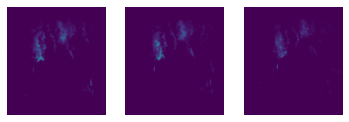

In [11]:
# plot 3 images with interval of 3 (=15m) between them
fig = plt.figure()
for i in range(0,9,3):
    path_file = path_ds  + '/' + radar_scans[288*50+i]


    with h5py.File(path_file, 'r') as h5f:
        radar_img = h5f['image1']['image_data'][:]

        # Plot the radar image
        # Set the masked pixel to 0 so that difference between pixel values can be better seen
        print(len(radar_img[radar_img==65535]))
        103989
       # radar_img[radar_img==65535] = 0
        nr_rainy_pixels = np.sum(radar_img >= 30)
        print('Rainy pixels (>0.3mm):', nr_rainy_pixels)
        print('No rain:', nr_rainy_pixels == 0)
        plt.subplot(1, 3, i/3 +1)
        plt.imshow(radar_img)
        plt.axis('off')

## Convert data to numpy arrays

Convert h5 files to dataframe. The dataframe has three columns: timestamp, radar image data and the mask image data.

In [32]:
def load_h5(file_path):
    radar_img = None
    with h5py.File(file_path, 'r') as f:
        try:
            radar_img = f['image1']['image_data'][:]
            
            ## Set pixels out of image to 0
            out_of_image = f['image1']['calibration'].attrs['calibration_out_of_image']
            radar_img[radar_img == out_of_image] = 0
            # Sometimes 255 or other number (244) is used for the calibration
            # for out of image values, so also check the first pixel
            radar_img[radar_img == radar_img[0][0]] = 0
            
        except:
            print("Error: could not read image1 data, file {}".format(file_path))
    return radar_img

def preprocess(in_dir, out_dir, year=None, label_dir=None):
    '''
    Preprocess the h5 file into numpy arrays. 
    The timestamp, image1 and image2 data of each file is stored
    '''
    # Create directory if it does not exist
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    if label_dir and not os.path.exists(label_dir):
        os.makedirs(label_dir)
    
    if year:
        radar_scans = sorted([f for f in os.listdir(in_dir) 
                              if (os.path.isfile(os.path.join(in_dir, f)) 
                                                                 and f.endswith('.h5')) 
                              and f.startswith('RAD_NL25_RAC_RT_{}'.format(year))])
    else:
        radar_scans = sorted([f for f in os.listdir(in_dir) 
                              if (os.path.isfile(os.path.join(in_dir, f)) and f.endswith('.h5'))])
    
    # Pattern for detecting timestamp in filename
    regex_file = re.compile('(\d{12})\.h5')
    
    for scan in tqdm(radar_scans):
        timestamp = int(regex_file.findall(scan)[0])
        scan_fn = out_dir + '/' + "{}.npy".format(timestamp)
            
        path_scan = in_dir + '/' + scan
        try:
            image1 = load_h5(path_scan)
            
            radar_data = np.array(image1)
            

            
            np.save(scan_fn, radar_data) 
            
            if label_dir:
                nr_rainy_pixels = np.sum(radar_img >= 30)
                no_rain_label = nr_rainy_pixels  == 0
                label_fn = label_dir + '/{}.npy'.format(timestamp)
                np.save(label_fn, no_rain_label)
        except:
            radar_data = np.zeros((765,700))
            np.save(scan_fn, radar_data)    
            if label_dir:
                no_rain_label = True
                label_fn = label_dir + '/{}.npy'.format(timestamp)
                np.save(label_fn, no_rain_label)       

In [36]:
in_dir = '/nobackup_1/users/schreurs/project_GAN/dataset_radar'
out_dir = '/nobackup_1/users/schreurs/project_GAN/dataset_radar_np'
label_dir = '/nobackup_1/users/schreurs/project_GAN/rtcor_rain_labels'
preprocess(in_dir, out_dir, year=2019, label_dir=label_dir)

 25%|██▌       | 26020/103853 [16:02<52:38, 24.64it/s]  

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201904021210.h5


 26%|██▌       | 26677/103853 [16:27<46:59, 27.37it/s]  

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201904041900.h5


 27%|██▋       | 27664/103853 [17:03<46:56, 27.05it/s]  

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201904080505.h5


 28%|██▊       | 29510/103853 [18:10<43:11, 28.69it/s]  

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201904141520.h5


 35%|███▌      | 36596/103853 [22:30<38:00, 29.49it/s]  

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201905090650.h5


 48%|████▊     | 49368/103853 [30:28<54:00, 16.81it/s]  

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201906222155.h5


 53%|█████▎    | 54717/103853 [33:45<37:14, 21.99it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201907111235.h5


 56%|█████▋    | 58470/103853 [36:05<29:15, 25.85it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201907241320.h5


 57%|█████▋    | 58964/103853 [36:24<28:03, 26.67it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201907260635.h5


 57%|█████▋    | 59174/103853 [36:32<32:50, 22.68it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201907270005.h5


 57%|█████▋    | 59348/103853 [36:39<30:41, 24.17it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201907271440.h5


 60%|██████    | 62578/103853 [38:41<24:54, 27.61it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201908072010.h5


 62%|██████▏   | 64674/103853 [39:59<31:23, 20.80it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201908150250.h5


 63%|██████▎   | 65373/103853 [40:26<23:09, 27.69it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201908171305.h5


 69%|██████▉   | 71609/103853 [44:21<16:56, 31.73it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201909080450.h5


 78%|███████▊  | 81142/103853 [50:24<12:42, 29.79it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201910130100.h5


 81%|████████▏ | 84640/103853 [52:40<11:42, 27.35it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201910260420.h5


 91%|█████████▏| 94970/103853 [59:25<06:54, 21.42it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201912010215.h5


 92%|█████████▏| 95732/103853 [59:56<08:24, 16.08it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201912031750.h5


 94%|█████████▎| 97130/103853 [1:00:52<03:56, 28.48it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201912081405.h5


 95%|█████████▍| 98504/103853 [1:01:50<04:14, 21.02it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201912130840.h5


 98%|█████████▊| 101387/103853 [1:03:50<02:11, 18.74it/s]

Error: could not read image1 data, file /nobackup_1/users/schreurs/project_GAN/dataset_radar/RAD_NL25_RAC_RT_201912230900.h5


100%|██████████| 103853/103853 [1:05:31<00:00, 26.42it/s]


In [14]:
from os import listdir
from os.path import isfile, join

radar_dir = '/nobackup_1/users/schreurs/project_GAN/dataset_radar_np/'
files = sorted([f for f in listdir(radar_dir) if isfile(join(radar_dir, f)) and f.startswith('2019')])
print(len(files))




for f in tqdm(files[12523:12523+100]):
    try:
        rdr = np.load(radar_dir+f)
        if rdr[0][0] != 0:
            print(f,rdr[0][0])
        rdr[rdr == rdr[0][0]] = 0
    except:
        print('error')
        rdr = np.zeros((765,700))
   

100%|██████████| 100/100 [00:00<00:00, 1330.60it/s]

103853
201902141215.npy 255
201902141220.npy 255
201902141225.npy 255
201902141230.npy 255


In [25]:
rdr = np.load(radar_dir+'201902141215.npy')
print(rdr[:5])
rdr[rdr == rdr[0][0]] = 0
rdr

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [24]:
np.save(radar_dir+'201902141215.npy',rdr)

## TODO: Pack data into sequences

Instead of storing 1 timestamp in 1 file, store a sequence of radarscans into 1 file. This will make loading the training data easier as the sequence of radarscans does not have to be made at runtime. These packages of sequences can later be linked with the target data.

First the radar scans are packed into sequences of 30 minutes (6 radarscans long). These can then be matched with the Aarts target data of 30 minutes ahead. This would mean that there are 288/6 = 48 sequences in a day(/folder)

TODO: This code was written for the wrong version of the dataset (recor). Still have to convert this to rtcor

In [ ]:
from os import listdir
from os.path import isfile, join

In [17]:
np_dir = '/nobackup/users/schreurs/project_GAN/dataset_radar_np/'
dir_30m = '/nobackup/users/schreurs/project_GAN/dataset_radar_np_30m/'

In [30]:
files = sorted([f for f in os.listdir(np_dir) if os.path.isfile(os.path.join(np_dir, f))
              and f.startswith('2019')])

In [29]:
files[:5]

['201901010000.npy',
 '201901010005.npy',
 '201901010010.npy',
 '201901010015.npy',
 '201901010020.npy']

In [154]:
def preprocess_into_sequences(in_dir, out_dir, n=6, year=2019):
    '''
    Preprocess the numpy files into sequences. 
    n is the length of the input sequence, default is 6 images (with interval of 5 resulting in 30 minutes)
    '''
    # Create directory if it does not exist
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    files = sorted([f for f in os.listdir(np_dir) if os.path.isfile(os.path.join(np_dir, f))
                  and f.startswith(year)])
    
    regex_file = re.compile('(\d{12})\.h5')
    # Each folder corresponds to a day
    for folder in tqdm(files[:100]):
        day_dir = in_dir + '/' 
        print(day_dir)
        # A new file each 5 minutes: 288 files in a day
        files = sorted([f for f in os.listdir(day_dir) if os.path.isfile(os.path.join(day_dir, f))])
        
        if len(files) != 288:
            print('Day {} has {} radar scans instead of 288'.format(folder, len(files)))
        for i in range(0,len(files)-n, n+1):
            sequence_i = files[i:i+n]
            
            sequence = []
            date_prev = None

            sequence_name = files[i].replace('.npy', 'seq{}m'.format(5*n))
            for file in sequence_i:
                file_path = day_dir + file
                timestamp, image = np.load(file_path, allow_pickle=True)
                
                if date_prev:
                    # check if interval is 5 
                    date_current = datetime.datetime.strptime(str(a), '%Y%m%d%H%M')
                    interval = int((date_current-date_prev).seconds / 60) 
        
                    if interval != 5:
                        print(date_current, date_prev, interval)
                    date_prev = date_current
                sequence.append(image)
            sequence = np.array(sequence)
            #np.save(out_dir+sequence_name, sequence)

In [155]:
preprocess_into_sequences(np_dir, dir_30m)

  0%|          | 0/100 [00:00<?, ?it/s]

/nobackup/users/schreurs/project_GAN/dataset_np/201812170755_201812180800/
Day 201812170755_201812180800 has 259 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/201812180755_201812190800/
Day 201812180755_201812190800 has 547 radar scans instead of 288


  2%|▏         | 2/100 [00:06<05:19,  3.26s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/201812190755_201812200800/
Day 201812190755_201812200800 has 488 radar scans instead of 288


  3%|▎         | 3/100 [00:12<06:57,  4.30s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/201812200755_201812210800/
Day 201812200755_201812210800 has 285 radar scans instead of 288


  4%|▍         | 4/100 [00:15<06:15,  3.91s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/201812210755_201812220800/
Day 201812210755_201812220800 has 277 radar scans instead of 288


  5%|▌         | 5/100 [00:18<05:52,  3.71s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181221T075500_20181222T080000/
Day 20181221T075500_20181222T080000 has 277 radar scans instead of 288


  6%|▌         | 6/100 [00:22<05:38,  3.60s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181222T080500_20181223T080000/
Day 20181222T080500_20181223T080000 has 286 radar scans instead of 288


  7%|▋         | 7/100 [00:25<05:30,  3.55s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181223T080500_20181224T080000/
Day 20181223T080500_20181224T080000 has 287 radar scans instead of 288


  8%|▊         | 8/100 [00:29<05:24,  3.52s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181224T080500_20181225T080000/
Day 20181224T080500_20181225T080000 has 286 radar scans instead of 288


  9%|▉         | 9/100 [00:32<05:14,  3.46s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181225T080500_20181226T080000/
Day 20181225T080500_20181226T080000 has 283 radar scans instead of 288


 10%|█         | 10/100 [00:35<05:07,  3.42s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181226T080500_20181227T080000/
Day 20181226T080500_20181227T080000 has 285 radar scans instead of 288


 11%|█         | 11/100 [00:39<05:03,  3.41s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181227T080500_20181228T080000/
Day 20181227T080500_20181228T080000 has 280 radar scans instead of 288


 12%|█▏        | 12/100 [00:42<04:59,  3.40s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181228T080500_20181229T080000/
Day 20181228T080500_20181229T080000 has 287 radar scans instead of 288


 13%|█▎        | 13/100 [00:46<04:58,  3.44s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181229T080500_20181230T080000/
Day 20181229T080500_20181230T080000 has 283 radar scans instead of 288


 14%|█▍        | 14/100 [00:49<04:55,  3.44s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181230T080500_20181231T080000/
Day 20181230T080500_20181231T080000 has 285 radar scans instead of 288


 15%|█▌        | 15/100 [00:52<04:50,  3.42s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181231T080500_20190101T080000/
Day 20181231T080500_20190101T080000 has 286 radar scans instead of 288


 16%|█▌        | 16/100 [00:56<04:48,  3.43s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190101T080500_20190102T080000/
Day 20190101T080500_20190102T080000 has 286 radar scans instead of 288


 17%|█▋        | 17/100 [00:59<04:43,  3.42s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190102T080500_20190103T080000/
Day 20190102T080500_20190103T080000 has 285 radar scans instead of 288


 18%|█▊        | 18/100 [01:03<04:38,  3.40s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190103T080500_20190104T080000/
Day 20190103T080500_20190104T080000 has 285 radar scans instead of 288


 19%|█▉        | 19/100 [01:06<04:29,  3.33s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190104T080500_20190105T080000/
Day 20190104T080500_20190105T080000 has 287 radar scans instead of 288


 20%|██        | 20/100 [01:09<04:30,  3.38s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190105T080500_20190106T080000/


 21%|██        | 21/100 [01:13<04:29,  3.41s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190106T080500_20190107T080000/


 22%|██▏       | 22/100 [01:16<04:25,  3.41s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190107T080500_20190108T080000/
Day 20190107T080500_20190108T080000 has 287 radar scans instead of 288


 23%|██▎       | 23/100 [01:20<04:22,  3.40s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190108T080500_20190109T080000/
Day 20190108T080500_20190109T080000 has 287 radar scans instead of 288


 24%|██▍       | 24/100 [01:23<04:18,  3.39s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190109T080500_20190110T080000/


 25%|██▌       | 25/100 [01:26<04:16,  3.43s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190110T080500_20190111T080000/
Day 20190110T080500_20190111T080000 has 286 radar scans instead of 288


 26%|██▌       | 26/100 [01:30<04:13,  3.42s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190111T080500_20190112T080000/
Day 20190111T080500_20190112T080000 has 283 radar scans instead of 288


 27%|██▋       | 27/100 [01:33<04:04,  3.35s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190112T080500_20190113T080000/
Day 20190112T080500_20190113T080000 has 259 radar scans instead of 288


 28%|██▊       | 28/100 [01:36<03:57,  3.29s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190113T080500_20190114T080000/
Day 20190113T080500_20190114T080000 has 286 radar scans instead of 288


 29%|██▉       | 29/100 [01:40<03:56,  3.33s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190114T080500_20190115T080000/
Day 20190114T080500_20190115T080000 has 285 radar scans instead of 288


 30%|███       | 30/100 [01:43<03:49,  3.27s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190115T080500_20190116T080000/
Day 20190115T080500_20190116T080000 has 287 radar scans instead of 288


 31%|███       | 31/100 [01:46<03:49,  3.32s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190116T080500_20190117T080000/
Day 20190116T080500_20190117T080000 has 285 radar scans instead of 288


 32%|███▏      | 32/100 [01:50<03:47,  3.34s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190117T080500_20190118T080000/
Day 20190117T080500_20190118T080000 has 283 radar scans instead of 288


 33%|███▎      | 33/100 [01:53<03:45,  3.37s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190118T080500_20190119T080000/
Day 20190118T080500_20190119T080000 has 281 radar scans instead of 288


 34%|███▍      | 34/100 [01:56<03:37,  3.29s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190119T080500_20190120T080000/
Day 20190119T080500_20190120T080000 has 283 radar scans instead of 288


 35%|███▌      | 35/100 [01:59<03:35,  3.32s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190120T080500_20190121T080000/
Day 20190120T080500_20190121T080000 has 283 radar scans instead of 288


 36%|███▌      | 36/100 [02:03<03:34,  3.35s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190121T080500_20190122T080000/
Day 20190121T080500_20190122T080000 has 284 radar scans instead of 288


 37%|███▋      | 37/100 [02:06<03:26,  3.28s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190122T080500_20190123T080000/
Day 20190122T080500_20190123T080000 has 282 radar scans instead of 288


 38%|███▊      | 38/100 [02:09<03:26,  3.32s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190123T080500_20190124T080000/
Day 20190123T080500_20190124T080000 has 284 radar scans instead of 288


 39%|███▉      | 39/100 [02:13<03:18,  3.26s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190124T080500_20190125T080000/
Day 20190124T080500_20190125T080000 has 280 radar scans instead of 288


 40%|████      | 40/100 [02:16<03:16,  3.28s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190125T080500_20190126T080000/
Day 20190125T080500_20190126T080000 has 281 radar scans instead of 288


 41%|████      | 41/100 [02:19<03:13,  3.28s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190126T080500_20190127T080000/
Day 20190126T080500_20190127T080000 has 277 radar scans instead of 288


 42%|████▏     | 42/100 [02:22<03:10,  3.29s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190127T080500_20190128T080000/
Day 20190127T080500_20190128T080000 has 277 radar scans instead of 288


 43%|████▎     | 43/100 [02:26<03:06,  3.28s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190128T080500_20190129T080000/
Day 20190128T080500_20190129T080000 has 274 radar scans instead of 288


 44%|████▍     | 44/100 [02:29<03:03,  3.28s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190129T080500_20190130T080000/
Day 20190129T080500_20190130T080000 has 278 radar scans instead of 288


 45%|████▌     | 45/100 [02:32<03:00,  3.27s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190130T080500_20190131T080000/
Day 20190130T080500_20190131T080000 has 279 radar scans instead of 288


 46%|████▌     | 46/100 [02:36<02:57,  3.29s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190131T080500_20190201T080000/
Day 20190131T080500_20190201T080000 has 280 radar scans instead of 288


 47%|████▋     | 47/100 [02:39<02:55,  3.31s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190201T080500_20190202T080000/
Day 20190201T080500_20190202T080000 has 280 radar scans instead of 288


 48%|████▊     | 48/100 [02:42<02:55,  3.37s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190202T080500_20190203T080000/
Day 20190202T080500_20190203T080000 has 282 radar scans instead of 288


 49%|████▉     | 49/100 [02:46<02:52,  3.39s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190203T080500_20190204T080000/
Day 20190203T080500_20190204T080000 has 280 radar scans instead of 288


 50%|█████     | 50/100 [02:49<02:47,  3.35s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190204T080500_20190205T080000/
Day 20190204T080500_20190205T080000 has 280 radar scans instead of 288


 51%|█████     | 51/100 [02:53<02:44,  3.35s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190205T080500_20190206T080000/
Day 20190205T080500_20190206T080000 has 281 radar scans instead of 288


 52%|█████▏    | 52/100 [02:56<02:40,  3.35s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190206T080500_20190207T080000/
Day 20190206T080500_20190207T080000 has 279 radar scans instead of 288


 53%|█████▎    | 53/100 [02:59<02:35,  3.31s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190207T080500_20190208T080000/
Day 20190207T080500_20190208T080000 has 283 radar scans instead of 288


 54%|█████▍    | 54/100 [03:02<02:33,  3.34s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190208T080500_20190209T080000/
Day 20190208T080500_20190209T080000 has 247 radar scans instead of 288


 55%|█████▌    | 55/100 [03:05<02:25,  3.23s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190209T080500_20190210T080000/
Day 20190209T080500_20190210T080000 has 281 radar scans instead of 288


 56%|█████▌    | 56/100 [03:09<02:22,  3.24s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190210T080500_20190211T080000/
Day 20190210T080500_20190211T080000 has 279 radar scans instead of 288


 57%|█████▋    | 57/100 [03:12<02:21,  3.28s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190211T080500_20190212T080000/
Day 20190211T080500_20190212T080000 has 283 radar scans instead of 288


 58%|█████▊    | 58/100 [03:16<02:20,  3.34s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190212T080500_20190213T080000/
Day 20190212T080500_20190213T080000 has 284 radar scans instead of 288


 59%|█████▉    | 59/100 [03:19<02:17,  3.36s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190213T080500_20190214T080000/
Day 20190213T080500_20190214T080000 has 281 radar scans instead of 288


 60%|██████    | 60/100 [03:22<02:14,  3.35s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190214T080500_20190215T080000/
Day 20190214T080500_20190215T080000 has 282 radar scans instead of 288


 61%|██████    | 61/100 [03:26<02:12,  3.39s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190215T080500_20190216T080000/
Day 20190215T080500_20190216T080000 has 286 radar scans instead of 288


 62%|██████▏   | 62/100 [03:29<02:08,  3.38s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190216T080500_20190217T080000/
Day 20190216T080500_20190217T080000 has 284 radar scans instead of 288


 63%|██████▎   | 63/100 [03:32<02:04,  3.36s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190217T080500_20190218T080000/
Day 20190217T080500_20190218T080000 has 284 radar scans instead of 288


 64%|██████▍   | 64/100 [03:35<01:52,  3.12s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190218T080500_20190219T080000/
Day 20190218T080500_20190219T080000 has 283 radar scans instead of 288


 66%|██████▌   | 66/100 [03:38<01:11,  2.11s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190219T080500_20190220T080000/
Day 20190219T080500_20190220T080000 has 287 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190220T080500_20190221T080000/


 67%|██████▋   | 67/100 [03:38<00:49,  1.51s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190221T080500_20190222T080000/
Day 20190221T080500_20190222T080000 has 287 radar scans instead of 288


 68%|██████▊   | 68/100 [03:41<01:04,  2.00s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190222T080500_20190223T080000/
Day 20190222T080500_20190223T080000 has 284 radar scans instead of 288


 69%|██████▉   | 69/100 [03:44<01:14,  2.40s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190223T080500_20190224T080000/


 70%|███████   | 70/100 [03:48<01:22,  2.74s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190224T080500_20190225T080000/
Day 20190224T080500_20190225T080000 has 285 radar scans instead of 288


100%|██████████| 100/100 [03:51<00:00,  2.32s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190225T080500_20190226T080000/
Day 20190225T080500_20190226T080000 has 1 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190226T080500_20190227T080000/
Day 20190226T080500_20190227T080000 has 1 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190227T080500_20190228T080000/
Day 20190227T080500_20190228T080000 has 1 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190228T080500_20190301T080000/
Day 20190228T080500_20190301T080000 has 1 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190301T080500_20190302T080000/
Day 20190301T080500_20190302T080000 has 1 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190302T080500_20190303T080000/
Day 20190302T080500_20190303T080000 has 1 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190303T080500_20190304T080000/
Day 20190303T080500

In [39]:
ls /nobackup_1/users/schreurs/project_GAN/dataset_np/201812170755_201812180800 |head

201812171030.npy
201812171035.npy
201812171040.npy
201812171045.npy
201812171050.npy
201812171055.npy
201812171100.npy
201812171105.npy
201812171110.npy
201812171115.npy


Some days seem to lack a lot of data. Maybe something went wrong during downloading these dates or during unpacking

In [26]:
ls /nobackup_1/users/schreurs/project_GAN/dataset_np/20190309T080500_20190310T080000/

201903100800.npy


In [11]:
ls /nobackup_1/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001

RAD_NL25_RAC_RE_201903100800.h5


In [19]:
ls /nobackup_1/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001.tar

/nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001.tar


As you can see there is only 1 radar scan of the date 2019-03-10. Below I unpack the tar file of that date again to test if something went wrong during the unpacking

In [20]:
# Testing path
tar_path = '/nobackup_1/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001.tar'
print("tar path: ", tar_path)
unpack_folder = tar_path.replace('.tar','')
print("unpack in folder: ", unpack_folder)

tar path:  /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001.tar
unpack in folder:  /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001


In [23]:
with tarfile.open(tar_path) as tar:
    tar.extractall(unpack_folder) 

In [24]:
ls /nobackup_1/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001

RAD_NL25_RAC_RE_201903100800.h5


Unpacking the tar files does not seem te be the problem.

When mannually download the tar file of 20190309T080500_20190310T080000 the radar data looks complete. During downloading the files probably got corrupted. 

Noticed a difference in dataset names: nl_rdr_data_rtcor_5m vs nl_rdr_data_recor_5m.
Currently using the recor dataset, the rtcor might have complete data unlike the rtcor. 

(Waiting on API request for bulk dowload rtcor instead of recor dataset)

Now got the API for the rtcor dataset. This dataset seems more complete